In [25]:
import ugradio
import numpy as np
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
# import pandas as pd


In [26]:
freq_0 = 1420.4058e6 # Hz
num_samples = 2048 
samp_rate = 3.2e6 # Hz
c_speed = 299792458 # m/s

In [49]:
def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

def fft(data, num_samp=2048, samp_rate=3.2e6):
    f = np.fft.fftshift(np.fft.fftfreq(num_samp, 1/samp_rate))
    Fx = np.fft.fftshift(np.fft.fft(data))
    return f, Fx

def average_power(data):
    f, Fx = fft(data)
    pwr = np.abs(Fx)**2
    avg_pwr = np.mean(pwr, axis=0)
    return f, avg_pwr

def adjust_freq_res(freqs, data, target_res):
    bins = int(samp_rate / target_res)
    bin_means, bin_edges, binnumber = binned_statistic(freqs, data, bins=bins)
    return bin_edges[:-1], bin_means


In [28]:
def freq_resolution(samp_rate, num_samples):
    result = samp_rate / num_samples
    return result

print('frequency resolution = ' + str(freq_resolution(samp_rate, 1600)) + ' [units of samp_rate]')

frequency resolution = 2000.0 [units of samp_rate]


# import data

In [29]:
pwd = '../data/'
fileList = ['on', 'off', 'cold', 'cal']

In [50]:
# pre-process data

raw_data = {}
pwr_data = {}
target_freq_res = 2e3 # Hz
# out_df_list = []

for fins in fileList:
    fname = f'{pwd}s_' + fins + '_3200.npy'
    data = np.load(fname)
    raw_data[fins] = data
    f, avg_pwr = average_power(data)
    f, avg_pwr = adjust_freq_res(f, avg_pwr, target_freq_res)
    
    # # LO = 1419
    # if fins in ['on']:
    #     f += freq_0 - 1 
    
    # # LO = 1420
    # elif fins in ['cold', 'cal']:
    #     f += freq_0 
        
    # LO = 1421
    if fins in ['off']:
        avg_pwr = np.flip(avg_pwr)
    
    pwr_data[fins] = [f, avg_pwr]
    
    # setup df
#     pre_df_dict = {}
#     pre_df_dict['freqs'], pre_df_dict[fins] = f, avg_pwr
#     pre_df = pd.DataFrame(pre_df_dict)
#     out_df_list += [pre_df]
    
# pwr_df = out_df_list[0]
# for df in out_df_list[1:]: 
#     pwr_df = pd.merge(pwr_df, df, how='outer', on='freqs')

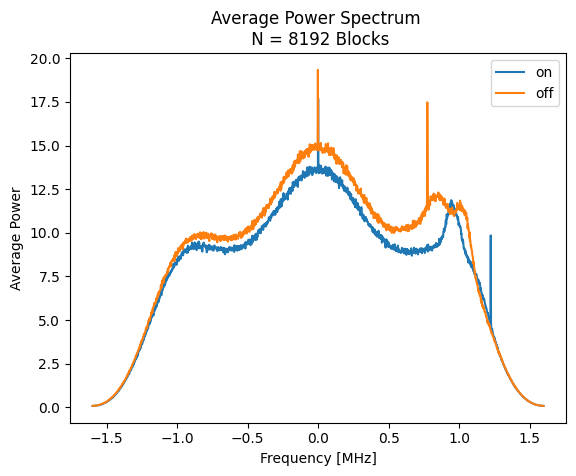

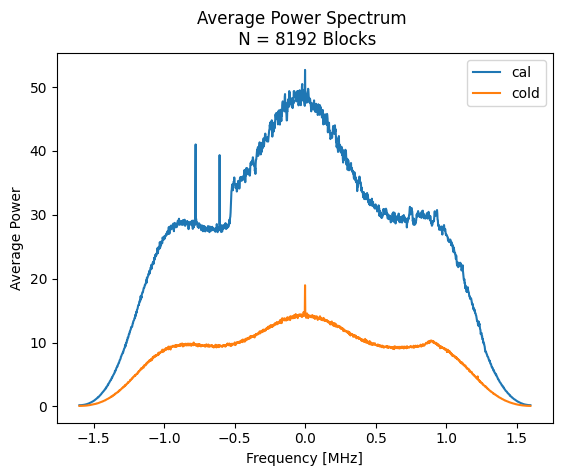

In [51]:
def plot_avg_power():
    
    dname = ['on', 'off']
    plt.figure()
    for name in dname:
        f, pwr = pwr_data[name]

        # plot average power
        plt.plot(f * 10**-6, pwr, label=name)
        
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Average Power')
    plt.title('Average Power Spectrum \n N = ' + '8192' + ' Blocks')
    plt.legend()
    plt.show()
    
    dname = ['cal', 'cold']
    plt.figure()
    for name in dname:
        f, pwr = pwr_data[name]

        # plot average power
        plt.plot(f * 10**-6, pwr, label=name)
        
        plt.xlabel('Frequency [MHz]')
        plt.ylabel('Average Power')
    plt.title('Average Power Spectrum \n N = ' + '8192' + ' Blocks')
    plt.legend()
    plt.show()

plot_avg_power()

# Find G

In [ ]:
s_on = pwr_data['on'][1]
s_off = pwr_data['off'][1]
s_cold = pwr_data['cold'][1]
s_cal = pwr_data['cal'][1]
f_domain = pwr_data['on'][0]

# calc s_line
s_line = s_on / s_off

# calc G
T = {'cal': 300, 'cold': 10}
fitband = np.abs(f_domain) <= 1.2e6
# G = ((T['cal'] - T['cold']) / np.sum(s_cal - s_cold)) * np.sum(s_cold) 
G_better7 = (T['cal'] - T['cold']) / np.mean(s_cal[fitband] - s_cold[fitband])
Trx_better7 = np.mean(G_better7 * s_cold[fitband])

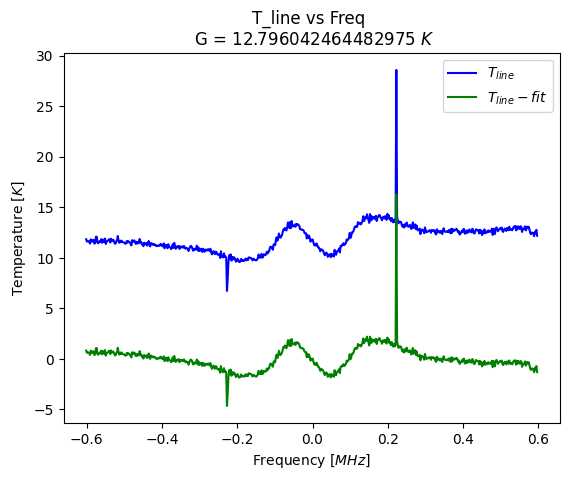

In [128]:
# calc T_line
T_line = np.multiply(s_line, G_better7) #- Trx_better7

# plot T_line
x = (f_domain[1000:]) * 10**-6 - 1
y = T_line[1000:]
plt.plot(x, y, color='blue', label='$T_{line}$')

# plot T_line - polyfit
fit = np.polyval(np.polyfit(x, y, 2), x)
plt.plot(x, y - fit, color='green', label='$T_{line} - fit$')

# plt.axvline(freq_0 * 10**-6, color='r', label=str(freq_0*10**-6)+ ' MHz')
plt.title('T_line vs Freq \n G = {} $K$'.format(str(G_better7)))
# plt.xlim(-.5, .5)
plt.xlabel('Frequency [$MHz$]')
plt.ylabel('Temperature [$K$]')
plt.legend()
plt.show()



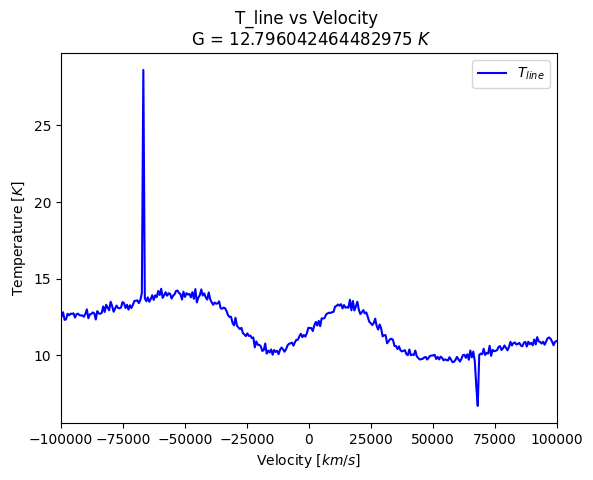

In [124]:
# freq to velocity domain conversion
LSR_corr = - 17589.206 # m/s (ADJUST!!)
v_domain = - (f_domain - 1e6) * c_speed / 1e6 + LSR_corr 

x = v_domain * 10**-3
y = T_line
plt.plot(v_domain * 10**-3, T_line, color='blue', label='$T_{line}$')
# plt.axvline(freq_0 * 10**-6, color='r', label=str(freq_0*10**-6)+ ' MHz')
plt.title('T_line vs Velocity \n G = {} $K$'.format(str(G_better7)))
plt.xlim(-10e4, 10e4)
plt.xlabel('Velocity [$km/s$]')
plt.ylabel('Temperature [$K$]')
plt.legend()
plt.show()